In [1]:
## XGBoost 
# State 1 hot 
# Rurality Data
# SVI poverty index
# Minority?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [2]:
main_path = Path.cwd().parent.parent
data_path = main_path / 'Data'

#svi = pd.read_csv( data_path / 'Master Project Data' /'SVI Tract Data.csv',  )


In [3]:
# import stored methods 
path = Path.cwd().parent.parent
LoadAndCleanACS = main_path /'src' /'data'/ 'LoadAndCleanACS.py'
LoadAndCleanARCP = main_path /'src' /'data'/ 'LoadAndCleanARCP.py'

# Run methods to obtain clean datasets 
%run $LoadAndCleanACS
%run $LoadAndCleanARCP


                     Pair Var 1                    Pair Var 2  Corr Value
59         house_pct_non_family          house_pct_live_alone    0.907753
25               race_pct_white              race_pct_whitenh    0.851387
36            race_pct_nonwhite           race_pct_nonwhitenh    0.851387
37            race_pct_nonwhite                race_pct_black    0.802072
48             house_pct_family      house_pct_family_married    0.757961
104    house_pct_complete_plumb    house_pct_complete_kitchen    0.752488
109  house_pct_incomplete_plumb  house_pct_incomplete_kitchen    0.752488
92         heat_pct_utility_gas          heat_pct_electricity   -0.732439
105    house_pct_complete_plumb  house_pct_incomplete_kitchen   -0.752488
108  house_pct_incomplete_plumb    house_pct_complete_kitchen   -0.752488
53     house_pct_family_married          house_pct_non_family   -0.757961
28               race_pct_white                race_pct_black   -0.802072
31             race_pct_whitenh       

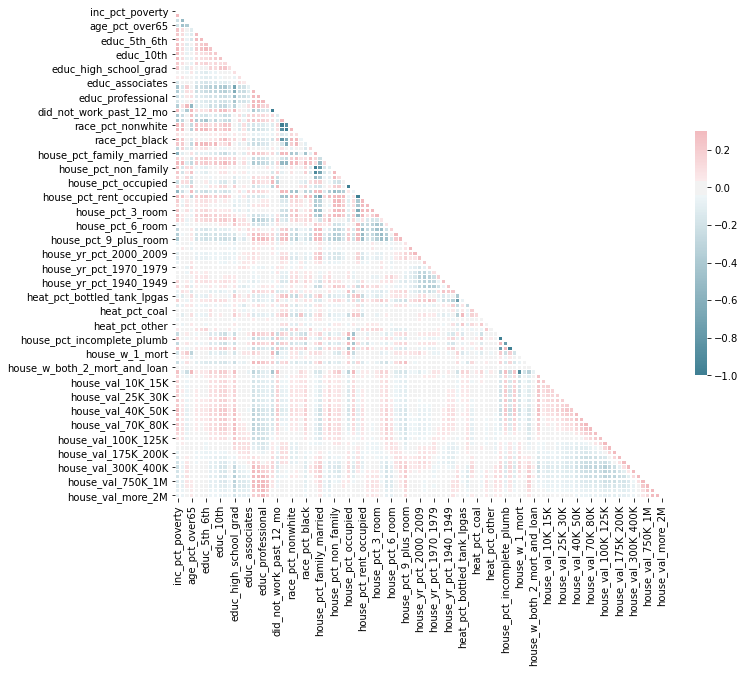

In [4]:
#Find correlated features in ACS dataset and identify the highly correlated relationships

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))


# Based on feature importance experiments, select features with consistence importance across annual predictions
ACS_reduced = ACS[['house_yr_pct_earlier_1939','house_yr_pct_1940_1949', 'house_pct_family_married', 'race_pct_white',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene','heat_pct_electricity','house_w_both_2_mort_and_loan', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad','educ_docterate','house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_500K_750K',
           'house_val_20K_25K','house_pct_family_female_hh']]


#From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh','house_no_mort',
                           'race_pct_black','house_pct_live_alone','house_pct_family_married'], axis=1) 





print (ACS.head())


In [5]:
# smoke detector statistical model munging
sm = pd.read_csv(  data_path /'Model Outputs'/'SmokeAlarmModelOutput.csv')
sm['geoid'] = sm['geoid'].str[2:]
sm['tract'] = sm['geoid'].str[:-1]
sm.drop(columns = 'Unnamed: 0', inplace = True)
sm.set_index('geoid', inplace =  True)
sm_all = sm.copy()
sm_all = sm[ sm['geography'].isin(['county','state']) ]

sm = sm[ sm['geography'].isin(['tract','block']) ]


In [6]:
def create_rurality_data(sm,subset_county = False): 
    #Rurality Data Munging 
    rd = pd.read_csv( data_path / 'Master Project Data' /'Tract Rurality Data.csv', dtype = {'FIPS':'object'},encoding = 'latin-1' )
    rd['Population Density (per square mile), 2010'] =  rd['Population Density (per square mile), 2010'].str.replace(',','').astype('float')
    rd = rd.iloc[:,[0,2,5,6,8]]
    block_tract = sm['tract'].to_frame()
    block_tract = block_tract.reset_index()
    rd = block_tract.merge(rd, how = 'left', left_on = 'tract' , right_on ='FIPS')
    rd.set_index('geoid',inplace= True)
    rd = rd.iloc[:,2:]
    rd['Select State'] = rd['Select State'].astype('category')

    # add state level model estimates 
    sms = pd.rd = pd.read_csv( data_path /'Model Outputs'/'Smoke_Alarm_Single_Level'/ 'SmokeAlarmModelState.csv')
    sms['geoid'] = sms['geoid'].str[2:]
    sms =  sms.loc[:,['geoid','detectors_found_prc']]
    sms = sms.rename(columns= {'geoid':'state_geoid'}  )

    rd['state_geoid'] = rd.index.str[:2]
    rd = rd.reset_index()
    rd = rd.merge(sms,how = 'left', on = 'state_geoid' )
    rd.drop('state_geoid',axis = 1,inplace = True)
    rd = rd.rename(columns = {'detectors_found_prc':'state_detectors_found_prc'}) 
    rd = rd.set_index('geoid')


    # add county level estimates
    smc = pd.read_csv( data_path /'Model Outputs'/'Smoke_Alarm_Single_Level'/ 'SmokeAlarmModelCounty.csv')
    smc['geoid'] = smc['geoid'].str[2:]
    if subset_county:
        smc.iloc[0::2,:] = np.nan
    smc =  smc.loc[:,['geoid','detectors_found_prc']]
    smc = smc.rename(columns= {'geoid':'county_geoid'}  )

    rd['county_geoid'] = rd.index.str[:5]
    rd = rd.reset_index()
    rd = rd.merge(smc,how = 'left', on = 'county_geoid' )
    rd.drop('county_geoid',axis = 1,inplace = True)
    rd = rd.rename(columns = {'detectors_found_prc':'county_detectors_found_prc'}) 
    rd = rd.set_index('geoid')
    rd = rd.iloc[:,3:]

    return rd 

# alternative 1 hot based encoding
#rd = rd.merge( pd.get_dummies(rd['Select State']), how = 'left', on= 'geoid')


In [7]:
rd = create_rurality_data(sm,True)
rd_all = create_rurality_data(sm_all)

In [41]:
def train_model(X = rd, y= sm, ACS = pd.DataFrame(),predict ='Presence', modeltype='XGBoost'):
    from scipy.stats import zscore, pearsonr
    from sklearn.metrics import auc, accuracy_score, confusion_matrix,mean_squared_error,mean_absolute_error,roc_auc_score, r2_score

    assert(predict in ['Presence', 'Working']) 
   
    
    # Define model types & parameters 
    
    if modeltype =='LinearRegression':
        from sklearn.linear_model import LinearRegression
        model = LinearRegression()
    if modeltype =='ElasticNet':    
        from sklearn.linear_model import ElasticNet
        model = ElasticNet()
    if modeltype =='Ridge':    
        from sklearn.linear_model import Ridge
        model = Ridge()
    if modeltype =='Lasso':    
        from sklearn.linear_model import Lasso
        model = Lasso()       
        
       
        
    elif modeltype =='XGBoost':
        import xgboost as xgb 
        model = xgb.XGBRegressor(objective = 'reg:squarederror',random_state = 0)
            
  
    if  predict == 'Presence':
        y = y['detectors_found_prc']
    elif predict =='Working':
        y = y['detectors_working_prc']


    # merge in ACS Data into X unless NFIRS-Only model
    if not ACS.empty:
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        X = X.dropna()
        y = y.filter(X.index)
    
    # Create 80/20 training/testing set split
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2 )

    # Perform cross-validation 

    #scaler = preprocessing.StandardScaler().fit(X)
    #scaler.transform(X)
    #print ('Cross Val Score:')
    #print(cross_val_score(model, X, y))

    # Standardize features by removing the mean and scaling to unit variance
    
    #scaler = preprocessing.StandardScaler().fit(X_train)
    #X_columns = X_train.columns
    #X_train =  pd.DataFrame(scaler.transform(X_train), columns = X_columns )
    #X_test  =  pd.DataFrame(scaler.transform(X_test) , columns = X_columns )

    # Fit model to training set

    model = model.fit(X_train,y_train)

    # Calculate training set performance
    train_predictions = model.predict(X_train)
    print('-----Training_Performance------')
    print(mean_squared_error(y_train, train_predictions))
    print ('Test RMSE: {}'.format(mean_squared_error(y_train, train_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_train, train_predictions)) )
    sns.scatterplot(y_train,train_predictions) 
    plt.show()
    
    # Calculate test set performance
    test_predictions = model.predict(X_test)
    print ('-----Test Performance ----- ')
    print ('Test RMSE: {}'.format(mean_squared_error(y_test, test_predictions, squared = False)) )
    print ('Test MAE: {}'.format(mean_absolute_error(y_test, test_predictions)) )
    sns.scatterplot(y_test,test_predictions) 
    plt.show()
    print ('Test Correlation: {}'.format(pearsonr(y_test, test_predictions)) )
    print ('Test R-squared: {}'.format(r2_score(y_test, test_predictions)) )


    #Calculate feature importance for each model
    if modeltype == 'XGBoost':
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        print("\n Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]])) 


    return  model,X_test,y_test



-----Training_Performance------
13.290496193876212
Test RMSE: 3.64561328090024
Test MAE: 2.6868087930681246


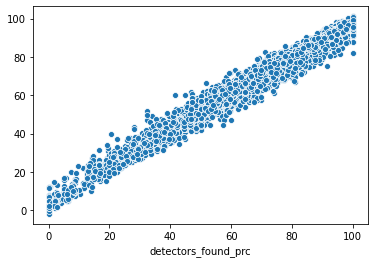

-----Test Performance ----- 
Test RMSE: 13.841066269315721
Test MAE: 10.19934528390233


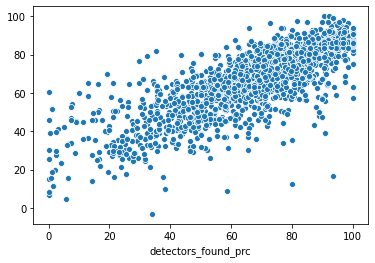

Test Correlation: (0.7669812667674595, 2.1521173983666453e-300)
Test R-squared: 0.5875408274665679

 Feature ranking:
1. county_detectors_found_prc (0.276563)
2. heat_pct_solar (0.020996)
3. heat_pct_fueloil_kerosene (0.019741)
4. race_pct_hisp (0.017223)
5. house_val_500K_750K (0.014414)
6. house_val_750K_1M (0.013959)
7. house_yr_pct_2010_2013 (0.011688)
8. house_yr_pct_1940_1949 (0.011100)
9. educ_5th_6th (0.011037)
10. house_yr_pct_earlier_1939 (0.011033)
11. house_yr_pct_1950_1959 (0.010955)
12. house_val_200K_250K (0.010761)
13. house_val_300K_400K (0.010681)
14. educ_masters (0.010505)
15. race_pct_amind (0.010446)
16. race_pct_white (0.010304)
17. house_pct_ownd_occupied (0.010210)
18. house_val_1M_1.5M (0.010120)
19. educ_nursery_4th (0.009991)
20. heat_pct_other (0.009692)
21. house_val_125K_150K (0.009597)
22. house_val_more_2M (0.009505)
23. house_pct_complete_plumb (0.009482)
24. educ_bachelors (0.009311)
25. house_pct_family (0.009095)
26. heat_pct_no_fuel (0.009066)
27. 

In [42]:
mdl,X_test,y_test = train_model(X = rd, y = sm , ACS = ACS  ,modeltype= 'XGBoost')

-----Training_Performance------
27.623035523103887
Test RMSE: 5.255762125810479
Test MAE: 3.824933526169013


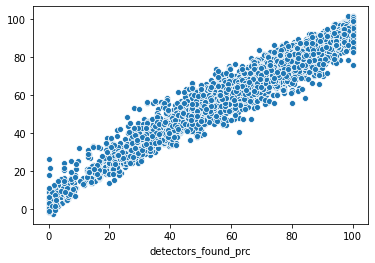

-----Test Performance ----- 
Test RMSE: 13.459836237685794
Test MAE: 9.852017482590723


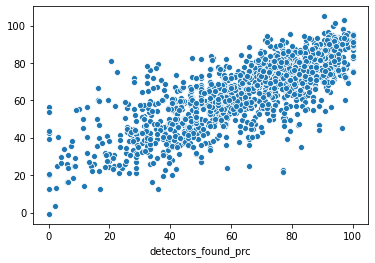

Test Correlation: (0.7874656232602081, 0.0)
Test R-squared: 0.6197583914772676

 Feature ranking:
1. county_detectors_found_prc (0.558237)
2. house_val_500K_750K (0.033427)
3. Population Density (per square mile), 2010 (0.027263)
4. educ_bachelors (0.026286)
5. educ_docterate (0.026253)
6. heat_pct_electricity (0.025759)
7. house_pct_ownd_occupied (0.025285)
8. house_pct_family_female_hh (0.024876)
9. educ_some_col_no_grad (0.024851)
10. house_w_home_equity_loan (0.024599)
11. heat_pct_fueloil_kerosene (0.023577)
12. race_pct_white (0.023034)
13. house_yr_pct_1940_1949 (0.022813)
14. worked_past_12_mo (0.021938)
15. house_pct_live_alone (0.020407)
16. house_val_20K_25K (0.020317)
17. state_detectors_found_prc (0.018960)
18. house_pct_family_married (0.018310)
19. house_yr_pct_earlier_1939 (0.017469)
20. house_w_both_2_mort_and_loan (0.016341)


In [43]:
mdl2,X_test,y_test =train_model(X = rd, y = sm , ACS = ACS_reduced  ,modeltype= 'XGBoost')

-----Training_Performance------
111.99054221701981
Test RMSE: 10.582558396579714
Test MAE: 7.788966270939744


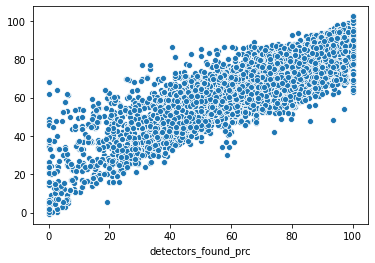

-----Test Performance ----- 
Test RMSE: 12.280305257772136
Test MAE: 8.947437991597713


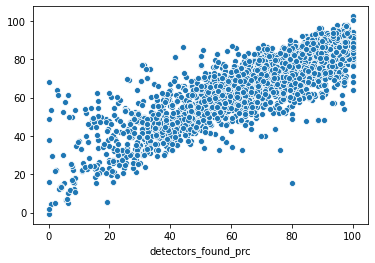

Test Correlation: (0.835502725308034, 0.0)
Test R-squared: 0.690861995162996

 Feature ranking:
1. county_detectors_found_prc (0.586410)
2. state_detectors_found_prc (0.302827)
3. Population Density (per square mile), 2010 (0.110763)


In [44]:
mdl3,X_test,y_test=train_model(X = rd, y = sm ,modeltype= 'XGBoost')

In [12]:
sm_all['Full_Predictions'] =  mdl.predict(rd_all.merge(ACS,how = 'left', left_index = True, right_index = True) )
sm_all['Reduced_ACS_Predictions'] =  mdl2.predict(rd_all.merge(ACS_reduced,how = 'left', left_index = True, right_index = True) )
sm_all['No_ACS_Predictions'] =  mdl3.predict(rd_all )
sm_all['Avg_Predictions']  = (sm_all['No_ACS_Predictions'] +sm_all['Reduced_ACS_Predictions']) /2 

In [38]:
sm_all.loc[:,['num_surveys','geography',
              'detectors_found_prc',
              'detectors_working_prc',
              'Full_Predictions',
              'Reduced_ACS_Predictions',
              'No_ACS_Predictions','Avg_Predictions'] ]
sm_all = sm_all.merge(rd_all['Population Density (per square mile), 2010'],how = 'left',left_index = True,right_index = True)
sm_all.index =  '#_' + sm_all.index 

In [39]:
sm_all.to_csv(path / 'Data' / 'Model Outputs' / 'SmokeAlarmPredictiveModel.csv')

In [35]:
sm_all.columns

Index(['num_surveys', 'detectors_found_total', 'detectors_found_prc',
       'detectors_found_CI', 'detectors_working_total',
       'detectors_working_prc', 'detectors_working_CI', 'geography', 'tract',
       'Full_Predictions', 'Reduced_ACS_Predictions', 'No_ACS_Predictions',
       'Avg_Predictions', 'Population Density (per square mile), 2010'],
      dtype='object')

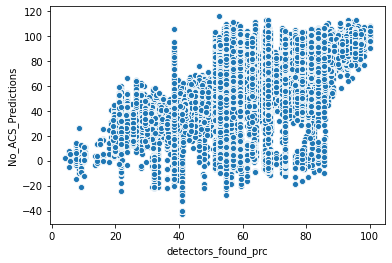

In [223]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['No_ACS_Predictions'])

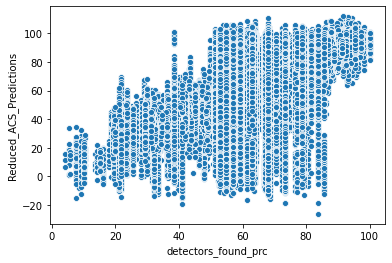

In [217]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Reduced_ACS_Predictions'])

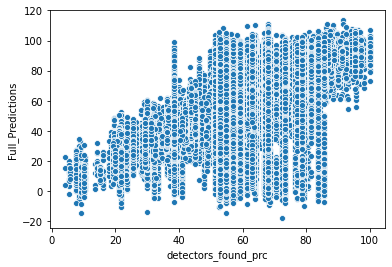

In [218]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Full_Predictions'])


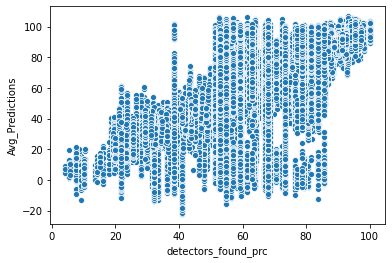

In [226]:
sns.scatterplot(sm_all['detectors_found_prc'],sm_all['Avg_Predictions'])


,num_surveys,detectors_found_total,detectors_found_prc,detectors_found_CI,detectors_working_total,detectors_working_prc,detectors_working_CI,geography,tract,Full_Predictions,Reduced_ACS_Predictions,No_ACS_Predictions,Avg_Predictions,"Population Density (per square mile), 2010"
geoid,,,,,,,,,,,,,,
010030101001,95.0,74.0,77.89,8.345061,50.0,52.63,10.040669,county,01003010100,61.123898,61.808304,77.996544,69.902420,10.1
010030101002,95.0,74.0,77.89,8.345061,50.0,52.63,10.040669,county,01003010100,69.866646,79.134796,77.996544,78.565674,10.1
010030101003,95.0,74.0,77.89,8.345061,50.0,52.63,10.040669,county,01003010100,75.119911,75.572075,77.996544,76.784309,10.1
010030102001,95.0,74.0,77.89,8.345061,50.0,52.63,10.040669,county,01003010200,75.918762,78.675682,77.053619,77.864655,33.9
010030102002,95.0,74.0,77.89,8.345061,50.0,52.63,10.040669,county,01003010200,79.838661,79.371201,77.053619,78.212410,33.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560459511001,892.0,562.0,63.00,3.168435,347.0,38.90,3.199404,state,56045951100,68.439285,62.137939,67.007301,64.572617,1.4
560459511002,892.0,562.0,63.00,3.168435,347.0,38.90,3.199404,state,56045951100,68.118340,56.862312,67.007301,61.934807,1.4
560459513001,892.0,562.0,63.00,3.168435,347.0,38.90,3.199404,state,56045951300,69.714798,64.558075,60.944233,62.751152,91.0
